In [47]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import statsmodels.api as sm
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import cPickle
import os
os.chdir('/Users/zbutler/research/fire_prediction')
from data import data
import prediction.cluster_regression
reload(prediction.cluster_regression)
from prediction.cluster_regression import ClusterRegression
from prediction.poisson_regression import evaluate_glm
%matplotlib inline

In [48]:
reload(data)
clust_feat_df = data.load_clust_feat_df(clust_thresh=5)
cr = ClusterRegression(clust_feat_df, 5, 'unused', 5)
def all_except_year(year, rng=(2007,2016)):
    return [x for x in range(rng[0],rng[1]+1) if x!=year]

pearson coefficient after clust df: (0.50489473230375381, 0.0)


In [162]:
# First, let's check out autocorrelation on the whole data to figure out how much we want to use
print "Autoreg\tIntercept\tCoef 1\tCoef 2\tCoef 3\tCoef4\tCoef 5"
for n_auto in xrange(1,6):
    ft = cr.fit(range(2007,2017), n_auto, weather_vars=[])
    print "%d\t%f\t" % (n_auto, ft.params["Intercept"]),
    for coef in xrange(1,n_auto+1):
        print "%f\t" % ft.params["autoreg_%d" % coef],
    print ""

Autoreg	Intercept	Coef 1	Coef 2	Coef 3	Coef4	Coef 5
1	0.657779	0.760214	
2	0.653876	0.715109	0.059872	
3	0.653579	0.714313	0.054589	0.008074	
4	0.643069	0.711653	0.052931	-0.049653	0.083195	
5	0.636713	0.706158	0.052691	-0.048987	0.027139	0.078379	


In [71]:
# How do coefficients vary depending on the testing data? We'll try holding out each year separately
ft = cr.fit(2010, 1, weather_vars=['temp','humidity','wind','rain'], standardize_covs=True)
param_names = ft.params.keys()
print "Covariates with rain (standardized)"
print "HO Year\t",
for param in param_names:
    print param + "\t",
print ""

for ho_year in xrange(2007, 2017):
    ft = cr.fit(all_except_year(ho_year), 1, weather_vars=['temp','humidity','wind','rain'], standardize_covs=True)
    print str(ho_year) + "\t",
    for param in param_names:
        print "%.3f\t\t" % ft.params[param],
    print ""
    
print "\n"

ft = cr.fit(2010, 1, weather_vars=['temp','humidity','wind','rain_del_2'], standardize_covs=True)
param_names = ft.params.keys()
print "Covariates with lagged rain (standardized)"
print "HO Year\t",
for param in param_names:
    print param + "\t",
print ""

for ho_year in xrange(2007, 2017):
    ft = cr.fit(all_except_year(ho_year), 1, weather_vars=['temp','humidity','wind','rain_del_2'], standardize_covs=True)
    print str(ho_year) + "\t",
    for param in param_names:
        print "%.3f\t\t" % ft.params[param],
    print ""

print "\n"
ft = cr.fit(2010, 1, weather_vars=['temp','humidity','wind','rain_del_2'], standardize_covs=False)
param_names = ft.params.keys()
print "Covariates with lagged rain (unstandardized)"
print "HO Year\t",
for param in param_names:
    print param + "\t",
print ""
for ho_year in xrange(2007, 2017):
    ft = cr.fit(all_except_year(ho_year), 1, weather_vars=['temp','humidity','wind','rain_del_2'], standardize_covs=False)
    print str(ho_year) + "\t",
    for param in param_names:
        print "%.3f\t\t" % ft.params[param],
    print ""

Covariates with rain (standardized)
HO Year	Intercept	autoreg_1	temp_stand	humidity_stand	wind_stand	rain_stand	
2007	0.684		0.732		0.229		-0.051		0.036		-0.003		
2008	0.661		0.736		0.230		-0.057		0.037		0.004		
2009	0.640		0.709		0.209		-0.045		0.070		-0.001		
2010	0.674		0.735		0.233		-0.056		0.046		0.004		
2011	0.650		0.737		0.230		-0.063		0.038		0.002		
2012	0.643		0.738		0.235		-0.059		0.040		0.003		
2013	0.708		0.723		0.250		-0.036		0.046		0.009		
2014	0.658		0.734		0.243		-0.046		0.033		0.004		
2015	0.474		0.780		0.273		-0.099		-0.042		-0.042		
2016	0.638		0.742		0.235		-0.047		0.058		0.005		


Covariates with lagged rain (standardized)
HO Year	Intercept	autoreg_1	temp_stand	humidity_stand	wind_stand	rain_del_2_stand	
2007	0.590		0.714		0.206		-0.043		0.029		-0.568		
2008	0.575		0.716		0.211		-0.043		0.032		-0.563		
2009	0.565		0.690		0.197		-0.030		0.065		-0.504		
2010	0.585		0.714		0.212		-0.045		0.041		-0.584		
2011	0.565		0.716		0.213		-0.048		0.033		-0.562		
2012	0.555		0.7

In [ ]:
# How much lag or whatever do the weather covariates "want"?
lag_arr_dict = dict()
w_vars = ["temp", "humidity", "wind", "rain"]
for var in w_vars:
    lag_arr_dict[var] = []
    
for t in xrange(-4, 4):
    series_dict = dict()
    for var in w_vars:
        series_dict[var] = dict()
    for clust in clust_feat_df.cluster.unique():
        clust_df = clust_feat_df[clust_feat_df.cluster == clust]
        days = clust_df.dayofyear.unique()
        for day in days:
            day_row = clust_df[clust_df.dayofyear==day]
            name = day_row.iloc[0].name
            delayed_weather_day = day - t
            for var in w_vars:
                if delayed_weather_day in days:
                    w_val = clust_df[clust_df.dayofyear==delayed_weather_day].iloc[0][var]
                    if np.isnan(w_val):
                        series_dict[var][name] = 0.
                    else:
                        series_dict[var][name] = w_val
                else:
                    series_dict[var][name] = 0.
    for var in w_vars:
        lag_arr_dict[var].append(pd.Series(series_dict[var]))

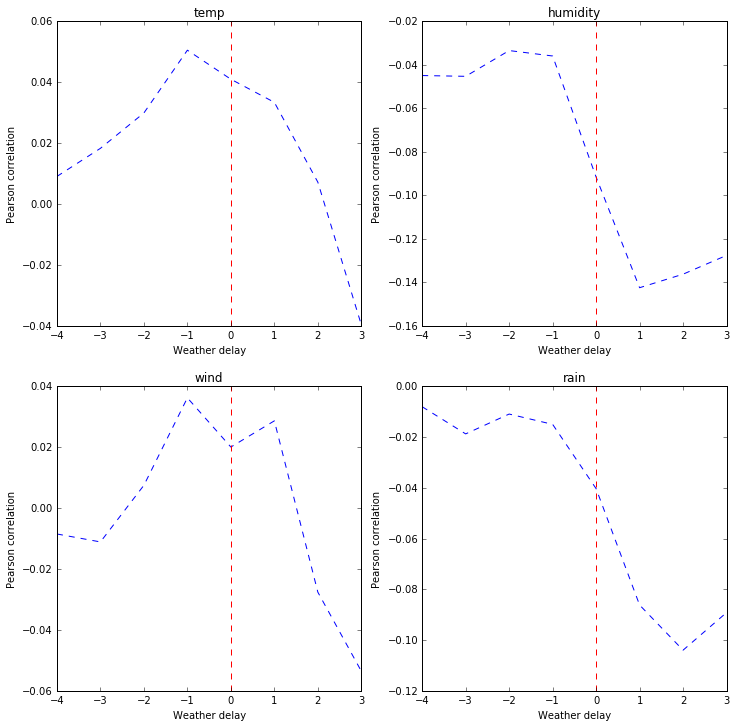

In [37]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12,12))
for i,var in enumerate(w_vars):
    ax = plt.subplot(221 + i)
    corrs = map(lambda x: pearsonr(clust_feat_df.n_det, x.loc[clust_feat_df.index]), lag_arr_dict[var])
    plt.plot(range(-4,4), map(lambda x: x[0], corrs), 'b--')
    plt.axvline(x=0, color='r', linestyle='--')
    plt.xlabel("Weather delay")
    plt.ylabel("Pearson correlation")
    plt.title(var)

plt.savefig("pics/weather_delay_fig.png")
plt.show()

In [117]:
# Make models that hold out every year
memory_mods = dict()
temphum_mods = dict()
weather_mods = dict()
only_weather_mods = dict()
weather_del_mods = dict()
for ho_year in xrange(2007, 2017):
    memory_mods[ho_year] = cr.fit(all_except_year(ho_year), 1, weather_vars=[])
    temphum_mods[ho_year] = cr.fit(all_except_year(ho_year), 1, weather_vars=["temp", "humidity"], standardize_covs=False)
    only_weather_mods[ho_year] = cr.fit(all_except_year(ho_year), 0, weather_vars=["temp", "humidity", "wind", "rain_del_2"], standardize_covs=False)
    weather_mods[ho_year] = cr.fit(all_except_year(ho_year), 1, weather_vars=["temp", "humidity", "wind", "rain"], standardize_covs=False)
    weather_del_mods[ho_year] = cr.fit(all_except_year(ho_year), 1, weather_vars=["temp", "humidity", "wind", "rain_del_2"], standardize_covs=False)

In [18]:
def get_lin_comb(df, params):
    lin_comb = np.zeros(len(df))
    for param, val in params.iteritems():
        if param == "Intercept":
            lin_comb += val
        else:
            lin_comb += val * df[param]
    lin_comb[np.isnan(lin_comb)] = np.mean(lin_comb)
    return lin_comb

MSE


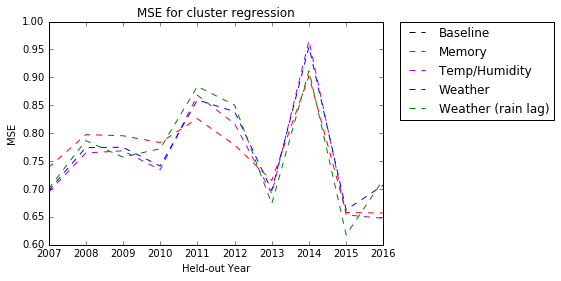

baseline overall: 682285.7
memory overall: 495844.921028
temphum overall: 484625.742776
weather overall: 491750.474144
rain lag overall: 474975.415497
RobustMSE


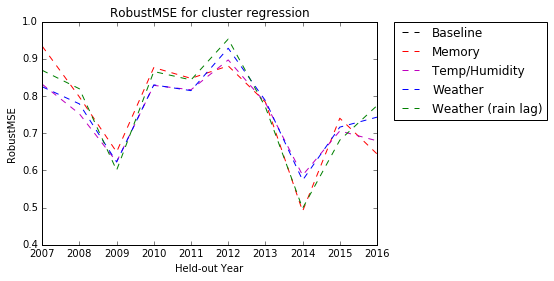

baseline overall: 309753.642119
memory overall: 219764.99302
temphum overall: 211860.6094
weather overall: 214299.967683
rain lag overall: 207693.939785
MeanAbsErr


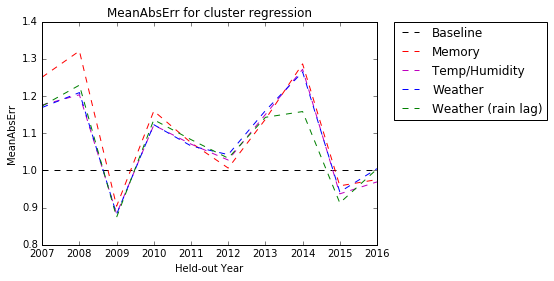

baseline overall: 9420.1
memory overall: 9416.66274897
temphum overall: 9227.18181865
weather overall: 9269.97270617
rain lag overall: 9121.86534467


In [118]:
import prediction.poisson_regression as pr
reload(pr)
from prediction.poisson_regression import evaluate_glm

# Let's plot overall error for each error type for each of our 5 models
n_occ = []
for year in xrange(2007, 2017):
    n_occ.append(len(clust_feat_df[clust_feat_df.year==year]))
n_occ = np.array(n_occ)
    
metrics =["MSE", "RobustMSE", "MeanAbsErr"]#, "ll"]
for met in metrics:
    print met
    year_range = np.arange(2007, 2017)
    baseline_met = np.zeros(len(year_range))
    memory_met = np.zeros(len(year_range))
    temphum_met = np.zeros(len(year_range))
    weather_met = np.zeros(len(year_range))
    weather_del_met = np.zeros(len(year_range))
    
    for i,year in enumerate(year_range):
        test_df = clust_feat_df[clust_feat_df.year==year]
        # Replace NaNs with value from nearest day we have data
        weather_covs = ["temp", "humidity", "wind", "rain", "rain_del_2"]
        for cov in weather_covs:
            nanners = test_df[np.isnan(test_df[cov])]
            for name in nanners.index:
                clust = nanners.loc[name].cluster
                dayofyear = nanners.loc[name].dayofyear
                next_offset_to_try = -1
                while 1:
                    # If offset is getting too far away, just replace with mean across all time
                    if abs(next_offset_to_try) > 5:
                        test_df.set_value(name, cov, np.mean(test_df[cov]))
                        break
                    pot_val = test_df[(test_df.dayofyear==(dayofyear+next_offset_to_try)) & (test_df.cluster==clust)][cov]
                    if not len(pot_val) or np.isnan(float(pot_val)):
                        if next_offset_to_try < 0:
                            next_offset_to_try = - next_offset_to_try
                        else:
                            next_offset_to_try = - (next_offset_to_try + 1)
                    else:
                        test_df.set_value(name, cov, float(pot_val))
                        break

        if met == "ll":
            memory_lins = get_lin_comb(test_df, memory_mods[year].params)
            memory_met[i] = evaluate_glm(test_df.n_det, test_df.autoreg_1, lins=memory_lins, metric=met)
            temphum_lins = get_lin_comb(test_df, temphum_mods[year].params)
            temphum_met[i] = evaluate_glm(test_df.n_det, test_df.autoreg_1, lins=temphum_lins, metric=met)
            weather_lins = get_lin_comb(test_df, weather_mods[year].params)
            weather_met[i] = evaluate_glm(test_df.n_det, test_df.autoreg_1, lins=weather_lins, metric=met)
            weather_del_lins = get_lin_comb(test_df, weather_del_mods[year].params)
            weather_del_met[i] = evaluate_glm(test_df.n_det, test_df.autoreg_1, lins=weather_del_lins, metric=met)
        else:
            n_out = int(.01 * len(test_df))
            baseline_met[i] = evaluate_glm(test_df.n_det, np.exp(test_df.autoreg_1)-1, metric=met, toss_outliers=n_out)
            memory_met[i] = evaluate_glm(test_df.n_det, memory_mods[year].predict(test_df), metric=met, toss_outliers=n_out)
            temphum_met[i] = evaluate_glm(test_df.n_det, temphum_mods[year].predict(test_df), metric=met, toss_outliers=n_out)
            weather_met[i] = evaluate_glm(test_df.n_det, weather_mods[year].predict(test_df), metric=met, toss_outliers=n_out)
            weather_del_met[i] = evaluate_glm(test_df.n_det, weather_del_mods[year].predict(test_df), metric=met, toss_outliers=n_out)

    if met != "ll":
        base = baseline_met
        plt.plot(year_range, baseline_met / base, 'k--', label='Baseline')
    else:
        base = map(lambda w,x,y,z: min(w,x,y,z), memory_met, temphum_met, weather_met, weather_del_met)
    plt.plot(year_range, memory_met/base, 'r--', label='Memory')
    plt.plot(year_range, temphum_met/base, 'm--', label='Temp/Humidity')
    plt.plot(year_range, weather_met/base, 'b--', label='Weather')
    plt.plot(year_range, weather_del_met/base, 'g--', label='Weather (rain lag)')
    plt.xlabel("Held-out Year")
    plt.ylabel(met)
    plt.title("%s for cluster regression" % met)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    ax = plt.gca()
    ax.get_xaxis().get_major_formatter().set_useOffset(False)
    plt.savefig("pics/cluster_model_%s.png" % met)
    plt.show()
    plt.close()
    
    if met != "ll":
        print "baseline overall: " + str(np.dot(n_occ, baseline_met) / len(n_occ))
    print "memory overall: " + str(np.dot(n_occ, memory_met) / len(n_occ))
    print "temphum overall: " + str(np.dot(n_occ, temphum_met) / len(n_occ))
    print "weather overall: " + str(np.dot(n_occ, weather_met) / len(n_occ))
    print "rain lag overall: " + str(np.dot(n_occ, weather_del_met) / len(n_occ))

46


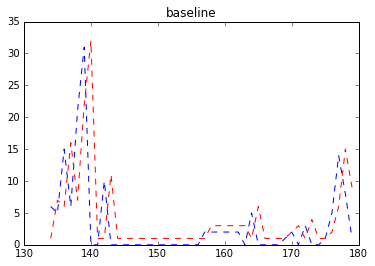

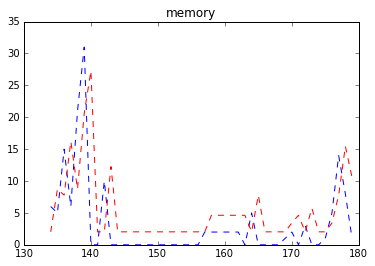

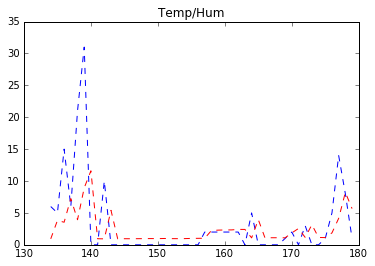

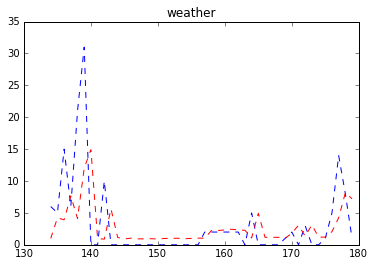

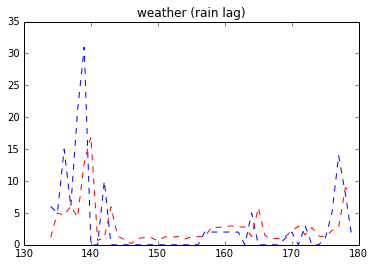

In [34]:
year = 2013
clust = clust_feat_df[clust_feat_df.year==2013].cluster.unique()[0]
clust_df = clust_feat_df[(clust_feat_df.year==year) & (clust_feat_df.cluster==clust)]
print len(clust_df)
ys = clust_df.n_det
y_hats = np.exp(clust_df.autoreg_1)-1
plt.plot(clust_df.dayofyear, ys, 'b--')
plt.plot(clust_df.dayofyear, y_hats, 'r--')
plt.title("baseline")
plt.show()
y_hats = memory_mods[year].predict(clust_df)
plt.plot(clust_df.dayofyear, ys, 'b--')
plt.plot(clust_df.dayofyear, y_hats, 'r--')
plt.title("memory")
plt.show()
y_hats = temphum_mods[year].predict(clust_df)
plt.plot(clust_df.dayofyear, ys, 'b--')
plt.plot(clust_df.dayofyear, y_hats, 'r--')
plt.title("Temp/Hum")
plt.show()
y_hats = weather_mods[year].predict(clust_df)
plt.plot(clust_df.dayofyear, ys, 'b--')
plt.plot(clust_df.dayofyear, y_hats, 'r--')
plt.title("weather")
plt.show()
y_hats = weather_del_mods[year].predict(clust_df)
plt.plot(clust_df.dayofyear, ys, 'b--')
plt.plot(clust_df.dayofyear, y_hats, 'r--')
plt.title("weather (rain lag)")
plt.show()

In [65]:
def kill_nans(test_df):
    weather_covs = ["temp", "humidity", "wind", "rain", "rain_del_2"]
    for cov in weather_covs:
        nanners = test_df[np.isnan(test_df[cov])]
        for name in nanners.index:
            clust = nanners.loc[name].cluster
            dayofyear = nanners.loc[name].dayofyear
            next_offset_to_try = -1
            while 1:
                # If offset is getting too far away, just replace with mean across all time
                if abs(next_offset_to_try) > 5:
                    test_df.set_value(name, cov, np.mean(test_df[cov]))
                    break
                pot_val = test_df[(test_df.dayofyear==(dayofyear+next_offset_to_try)) & (test_df.cluster==clust)][cov]
                if not len(pot_val) or np.isnan(float(pot_val)):
                    if next_offset_to_try < 0:
                        next_offset_to_try = - next_offset_to_try
                    else:
                        next_offset_to_try = - (next_offset_to_try + 1)
                else:
                    test_df.set_value(name, cov, float(pot_val))
                    break
    return test_df

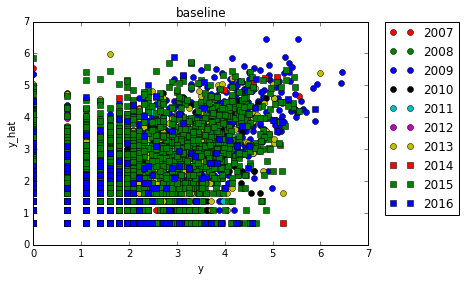

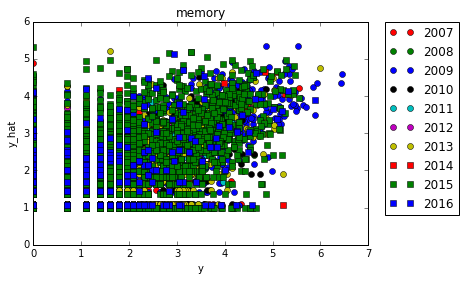

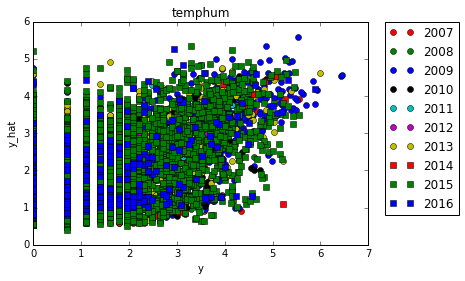

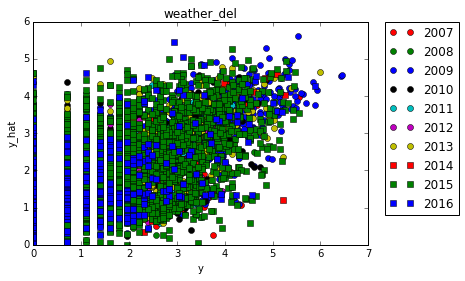

In [66]:
colors = ['r','g','b','k','c','m','y']
for mod_type in ['baseline', 'memory', 'temphum', 'weather_del']:
    for i,year in enumerate(xrange(2007, 2017)):
        test_df = clust_feat_df[clust_feat_df.year==year]
        test_df = kill_nans(test_df)
        y = test_df.n_det
        if mod_type == 'baseline':
            y_hat = np.exp(test_df.autoreg_1)-1
        elif mod_type == 'memory':
            y_hat = memory_mods[year].predict(test_df)
        elif mod_type == 'temphum':
            y_hat = temphum_mods[year].predict(test_df)
        elif mod_type == 'weather_del':
            y_hat = weather_del_mods[year].predict(test_df)
        color = colors[i % len(colors)]
        if i < len(colors):
            marker = 'o'
        else:
            marker = 's'
        plt.plot(np.log(y+1), np.log(y_hat+1), color + marker, label=year)
    plt.xlabel("y")
    plt.ylabel("y_hat")
    plt.title(mod_type)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

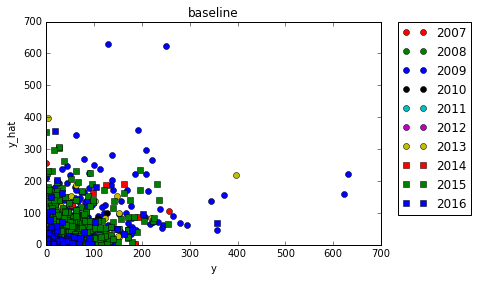

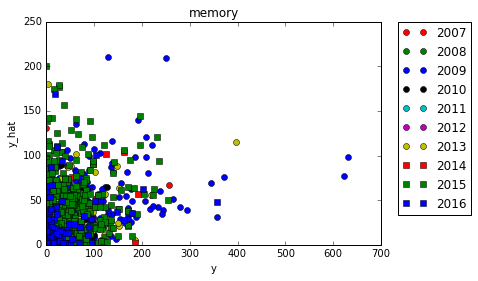

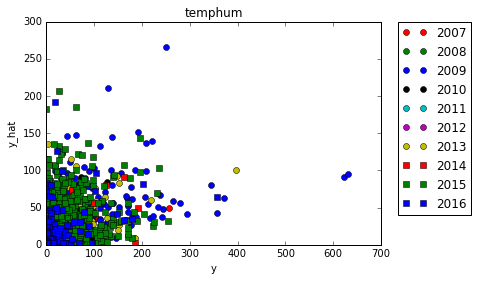

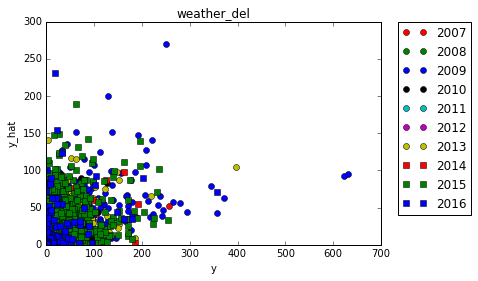

In [67]:
colors = ['r','g','b','k','c','m','y']
for mod_type in ['baseline', 'memory', 'temphum', 'weather_del']:
    for i,year in enumerate(xrange(2007, 2017)):
        test_df = clust_feat_df[clust_feat_df.year==year]
        test_df = kill_nans(test_df)
        y = test_df.n_det
        if mod_type == 'baseline':
            y_hat = np.exp(test_df.autoreg_1)-1
        elif mod_type == 'memory':
            y_hat = memory_mods[year].predict(test_df)
        elif mod_type == 'temphum':
            y_hat = temphum_mods[year].predict(test_df)
        elif mod_type == 'weather_del':
            y_hat = weather_del_mods[year].predict(test_df)
        color = colors[i % len(colors)]
        if i < len(colors):
            marker = 'o'
        else:
            marker = 's'
        plt.plot(y, y_hat, color + marker, label=year)
    plt.xlabel("y")
    plt.ylabel("y_hat")
    plt.title(mod_type)
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.show()

In [97]:
print np.sum(np.isnan(clust_feat_df.rain))
print len(clust_feat_df)
for clust in clust_feat_df.cluster.unique():
    if len(clust_feat_df[clust_feat_df.cluster==clust].year.unique()) != 1:
        print "oh no %d" % clust
print 'yay'
clust_feat_df.iloc[0:10]

577
12810
yay


,cluster,alt_cluster,lat_centroid,lon_centroid,n_det,dayofyear,year,rain,wind,temp,humidity,rain_del_2,autoreg_1,autoreg_2,autoreg_3,autoreg_4,autoreg_5
0,0.0,NaN,60.0460,-151.492,1.0,137.0,2007.0,0.0,3.324154,282.3,57.0,0.6,0.000000,0.000000,0.000000,0.000000,0.000000
1,1.0,NaN,67.0195,-158.289,1.0,139.0,2007.0,0.0,1.081665,276.1,98.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2,1.0,NaN,67.0195,-158.289,0.0,140.0,2007.0,0.0,0.300000,277.2,94.0,0.0,0.693147,0.000000,0.000000,0.000000,0.000000
3,1.0,NaN,67.0195,-158.289,0.0,141.0,2007.0,1.1,1.941649,275.8,100.0,0.0,0.000000,0.693147,0.000000,0.000000,0.000000
4,1.0,NaN,67.0195,-158.289,0.0,142.0,2007.0,5.3,2.195450,278.0,99.0,0.0,0.000000,0.000000,0.693147,0.000000,0.000000
5,1.0,NaN,67.0195,-158.289,0.0,143.0,2007.0,0.1,2.570992,277.0,99.0,1.1,0.000000,0.000000,0.000000,0.693147,0.000000
6,1.0,NaN,67.0195,-158.289,0.0,144.0,2007.0,0.1,3.676955,278.0,98.0,5.3,0.000000,0.000000,0.000000,0.000000,0.693147
7,1.0,NaN,67.0195,-158.289,0.0,145.0,2007.0,0.1,2.630589,282.6,85.0,0.1,0.000000,0.000000,0.000000,0.000000,0.000000
8,1.0,NaN,67.0195,-158.289,0.0,146.0,2007.0,0.0,2.570992,280.2,85.0,0.1,0.000000,0.000000,0.000000,0.000000,0.000000
9,1.0,NaN,67.0195,-158.289,0.0,147.0,2007.0,0.0,1.431782,279.1,84.0,0.1,0.000000,0.000000,0.000000,0.000000,0.000000


Time to make some data for Padhraic. Rows will be fire events, and i will have the following columns:
* clust ID
* clust ID of merger
* dayofyear
* day of cluster
* year
* lat
* lon
* y_t
* y_t-1
* weather
* y_hat[memory]
* y_hat[temphum]
* y_hat[weather_no_autoreg]
* y_hat[weather]

In [144]:
with open("data/prediction_summary.csv", "w") as fout:
    fout.write("clustID,clustIDmerge,dayOfYear,dayOfClust,year,lat,lon,y_t,y_t-1,temp,humidity,wind,delRain,yhat_mem,yhat_temphum,yhat_onlyweather,yhat_all\n")
    gtfo = 0
    for clust in clust_feat_df.cluster.unique():
        clust_df = clust_feat_df[clust_feat_df.cluster==clust]
        alt_clust = clust_df.iloc[0].alt_cluster
        if isinstance(alt_clust, tuple):
            alt_clust = alt_clust[0]
        else:
            alt_clust = -1
        year = clust_df.iloc[0].year
        lat = clust_df.iloc[0].lat_centroid
        lon = clust_df.iloc[0].lon_centroid
        days = np.sort(clust_df.dayofyear.unique())
        for i,day in enumerate(days):
            fout.write("%d,%d,%d,%d,%d,%f,%f," % (int(clust), int(alt_clust), int(day), i, int(year), lat, lon))
            row = clust_df[clust_df.dayofyear==day].iloc[0]
            for var in ['temp','humidity','wind','rain_del_2']:
                next_offset_to_try = -1
                while np.isnan(row[var]):
                    # If offset is getting too far away, just replace with mean across that day
                    if abs(next_offset_to_try) > 5:
                        row[var] = np.mean(clust_feat_df[(clust_feat_df.year==year) & (clust_feat_df.dayofyear==dayofyear)][var])
                        if np.isnan(row[var]):   # If we still can't do that, replace with the mean for the past 2 weeks week
                            row[var] = np.mean(clust_feat_df[(clust_feat_df.year==year) & (abs(clust_feat_df.dayofyear - dayofyear) < 7)][var])
                        break
                    #print "boop: " + str(clust_df[(clust_df.dayofyear==(dayofyear+next_offset_to_try))])
                    pot_val = clust_df[(clust_df.dayofyear==(dayofyear+next_offset_to_try))][cov]
                    if not len(pot_val) or np.isnan(float(pot_val)):
                        if next_offset_to_try < 0:
                            next_offset_to_try = - next_offset_to_try
                        else:
                            next_offset_to_try = - (next_offset_to_try + 1)
                    else:
                        row[var] = float(pot_val)
                        break
            try:
                fout.write("%d,%d,%f,%f,%f,%f," % (row.n_det, np.exp(row.autoreg_1)-1, row.temp, row.humidity, row.wind, row.rain_del_2))
                fout.write("%f,%f,%f,%f\n" % (memory_mods[year].predict(row)[0], temphum_mods[year].predict(row)[0], only_weather_mods[year].predict(row)[0], weather_del_mods[year].predict(row)[0]))
            except IndexError:
                print row
                print next_offset_to_try
                print clust_feat_df[(clust_feat_df.year==year) & (clust_feat_df.dayofyear==dayofyear)][var]
                gtfo = 1
                break
        if gtfo:
            break

In [159]:
reload(prediction.cluster_regression)
from prediction.cluster_regression import ClusterRegression
cr = ClusterRegression(clust_feat_df, 5, 'unused', 5)
ft = cr.fit(range(2007,2017), 1, weather_vars=['temp','humidity','wind','rain_del_2'], standardize_covs=True)
param_names = ft.params.keys()
print "Covariates with lagged rain (standardized)"
for param in param_names:
    print param + "\t",
print ""

for param in param_names:
    print "%.3f\t\t" % ft.params[param],
print ""
print "\n"

ft = cr.fit(range(2007,2017), 1, weather_vars=['temp','humidity','wind','rain_del_2'], standardize_covs=False)
param_names = ft.params.keys()
print "Covariates with lagged rain (unstandardized)"
for param in param_names:
    print param + "\t",
print ""

for param in param_names:
    print "%.3f\t\t" % ft.params[param],
print ""

prediction/cluster_regression.py:140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  train_df["autoreg_%d_stand" % reg] = (col - np.mean(col)) / np.std(col)
prediction/cluster_regression.py:142: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  train_df[var + "_stand"] = (train_df[var] - np.mean(train_df[var])) / np.std(train_df[var])


Covariates with lagged rain (standardized)
Intercept	autoreg_1_stand	temp_stand	humidity_stand	wind_stand	rain_del_2_stand	
1.138		0.935		0.217		-0.043		0.033		-0.556		


Covariates with lagged rain (unstandardized)
Intercept	autoreg_1	temp	humidity	wind	rain_del_2	
-9.473		0.717		0.035		-0.002		0.022		-0.163		


In [161]:
cr.clust_df.iloc[0:5]

,cluster,alt_cluster,lat_centroid,lon_centroid,n_det,dayofyear,year,rain,wind,temp,humidity,rain_del_2,autoreg_1,autoreg_2,autoreg_3,autoreg_4,autoreg_5
0,0.0,NaN,60.0460,-151.492,1.0,137.0,2007.0,0.0,3.324154,282.3,57.0,0.6,0.000000,0.000000,0.000000,0.0,0.0
1,1.0,NaN,67.0195,-158.289,1.0,139.0,2007.0,0.0,1.081665,276.1,98.0,0.0,0.000000,0.000000,0.000000,0.0,0.0
2,1.0,NaN,67.0195,-158.289,0.0,140.0,2007.0,0.0,0.300000,277.2,94.0,0.0,0.693147,0.000000,0.000000,0.0,0.0
3,1.0,NaN,67.0195,-158.289,0.0,141.0,2007.0,1.1,1.941649,275.8,100.0,0.0,0.000000,0.693147,0.000000,0.0,0.0
4,1.0,NaN,67.0195,-158.289,0.0,142.0,2007.0,5.3,2.195450,278.0,99.0,0.0,0.000000,0.000000,0.693147,0.0,0.0


In [163]:
np.exp(.65)

1.9155408290138962